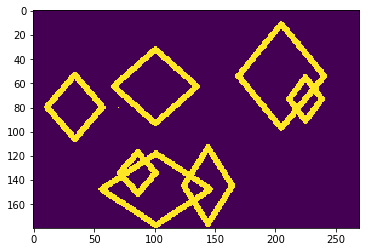

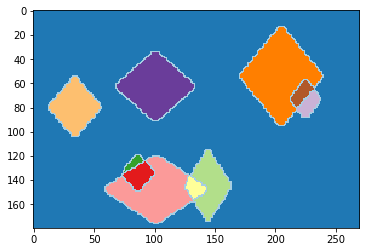

In [8]:
import numpy as np
from collections import deque
import numpy as np
from skimage import  io, filters
from skimage.util import img_as_ubyte
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.misc import imsave


class Watershed(object):
    MASK = -2
    WSHD = 0
    INIT = -1
    INQE = -3

    def __init__(self, levels=256):
        self.levels = levels

    def _get_neighbors(self, height, width, pixel):
        return np.mgrid[
               max(0, pixel[0] - 1):min(height, pixel[0] + 2),
               max(0, pixel[1] - 1):min(width, pixel[1] + 2)
               ].reshape(2, -1).T

    def apply(self, image):
        current_label = 0
        flag = False
        fifo = deque()

        height, width = image.shape
        total = height * width
        labels = np.full((height, width), self.INIT, np.int32)

        reshaped_image = image.reshape(total)
        # [y, x] pairs of pixel coordinates of the flattened image.
        pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
        # coordinates of neighbour pixels for each pixel.
        neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])
        if len(neighbours.shape) == 3:
            # Case where all pixels have the same number of neighbours.
            neighbours = neighbours.reshape(height, width, -1, 2)
        else:
            # Case where pixels may have a different number of pixels.
            neighbours = neighbours.reshape(height, width)

        indices = np.argsort(reshaped_image)
        sorted_image = reshaped_image[indices]
        sorted_pixels = pixels[indices]

        # self.levels evenly spaced steps from minimum to maximum.
        levels = np.linspace(sorted_image[0], sorted_image[-1], self.levels)
        level_indices = []
        current_level = 0

        # get the indices that deleimit pixels with different values.
        for i in range(total):
            if sorted_image[i] > levels[current_level]:
                # Skip levels until the next highest one is reached.
                while sorted_image[i] > levels[current_level]: current_level += 1
                level_indices.append(i)
        level_indices.append(total)

        start_index = 0
        for stop_index in level_indices:
            # Mask all pixels at the current level.
            for p in sorted_pixels[start_index:stop_index]:
                labels[p[0], p[1]] = self.MASK
                # Initialize queue with neighbours of existing basins at the current level.
                for q in neighbours[p[0], p[1]]:
                    if labels[q[0], q[1]] >= self.WSHD:
                        labels[p[0], p[1]] = self.INQE
                        fifo.append(p)
                        break

            # Extend basins.
            while fifo:
                p = fifo.popleft()
                # Label p by inspecting neighbours.
                for q in neighbours[p[0], p[1]]:
                    # Don't set lab_p in the outer loop because it may change.
                    lab_p = labels[p[0], p[1]]
                    lab_q = labels[q[0], q[1]]
                    if lab_q > 0:
                        if lab_p == self.INQE or (lab_p == self.WSHD and flag):
                            labels[p[0], p[1]] = lab_q
                        elif lab_p > 0 and lab_p != lab_q:
                            labels[p[0], p[1]] = self.WSHD
                            flag = False
                    elif lab_q == self.WSHD:
                        if lab_p == self.INQE:
                            labels[p[0], p[1]] = self.WSHD
                            flag = True
                    elif lab_q == self.MASK:
                        labels[q[0], q[1]] = self.INQE
                        fifo.append(q)

            # Detect and process new minima at the current level.
            for p in sorted_pixels[start_index:stop_index]:
                # p is inside a new minimum. Create a new label.
                if labels[p[0], p[1]] == self.MASK:
                    current_label += 1
                    fifo.append(p)
                    labels[p[0], p[1]] = current_label
                    while fifo:
                        q = fifo.popleft()
                        for r in neighbours[q[0], q[1]]:
                            if labels[r[0], r[1]] == self.MASK:
                                fifo.append(r)
                                labels[r[0], r[1]] = current_label

            start_index = stop_index

        return labels


if __name__ == "__main__":


    w = Watershed()
    image = img_as_ubyte(io.imread('images/i4.png', as_binary=True))[:, :, 0]
    plt.imshow(image)
    plt.show()
    labels_ = w.apply(image)
    plt.imshow(labels_, cmap='Paired', interpolation='nearest')
    plt.show()


In [ ]:
w = Watershed()
image = img_as_ubyte(io.imread('images/img5.png', as_binary=True))[:, :, 0]
plt.imshow(image)
plt.show()
labels_ = w.apply(image)
    plt.imshow(labels_, cmap='Paired', interpolation='nearest')
    plt.show()